In [ ]:
import sys
import os
# Agrega la raíz del proyecto al path
sys.path.append(os.path.abspath(os.path.join('..')))

from src.extract.google_trends import fetch_trends_data
from src.config.keywords import FINTECH_KEYWORDS
from src.config.countries import COUNTRIES 

In [ ]:
df_test = fetch_trends_data("billetera digital","PE")
df_test.head()

,date,keyword,country_code,interest_score
0,2019-01-01,billetera digital,PE,0
1,2019-02-01,billetera digital,PE,0
2,2019-03-01,billetera digital,PE,0
3,2019-04-01,billetera digital,PE,0
4,2019-05-01,billetera digital,PE,0


In [ ]:
df_test.describe()

,date,interest_score
count,73,73.000000
mean,2021-12-31 04:16:26,3.342466
min,2019-01-01 00:00:00,0.000000
25%,2020-07-01 00:00:00,0.000000
50%,2022-01-01 00:00:00,1.000000
75%,2023-07-01 00:00:00,2.000000
max,2025-01-01 00:00:00,100.000000
std,NaN,12.087895


In [17]:
df_test["interest_score"].max()

np.int64(100)

In [ ]:
df_test = fetch_trends_data("Yape", "PE")
df_test.head()
df_test.describe()

,date,interest_score
count,73,73.000000
mean,2021-12-31 04:16:26,46.410959
min,2019-01-01 00:00:00,3.000000
25%,2020-07-01 00:00:00,25.000000
50%,2022-01-01 00:00:00,45.000000
75%,2023-07-01 00:00:00,73.000000
max,2025-01-01 00:00:00,100.000000
std,NaN,29.375838


In [ ]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from src.transform.clean_transform import clean_trends_dataframe

df_raw = fetch_trends_data("Yape", "PE")
df_clean = clean_trends_dataframe(df_raw)
df_clean.info()

<class 'pandas.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype        
---  ------          --------------  -----        
 0   date            73 non-null     datetime64[s]
 1   keyword         73 non-null     str          
 2   country_code    73 non-null     str          
 3   interest_score  73 non-null     int64        
dtypes: datetime64[s](1), int64(1), str(2)
memory usage: 2.4 KB


In [ ]:
import pandas as pd
import time
import random

from src.extract.google_trends import fetch_trends_data
from src.transform.clean_transform import clean_trends_dataframe
from src.config.keywords import FINTECH_KEYWORDS
from src.config.countries import COUNTRIES


In [ ]:
import os

DATA_PATH = "../data/raw/google_trends_master.csv"

downloaded_combos = set()
if os.path.exists(DATA_PATH):
    try:
        df_existing = pd.read_csv(DATA_PATH)
        if not df_existing.empty:
            # Creacion de set
            downloaded_combos = set(zip(df_existing['country_code'], df_existing['keyword']))
            print(f"✅ Se detectaron {len(downloaded_combos)} combinaciones ya descargadas. Saltándolas...")
    except Exception as e:
        print(f"El archivo existe pero no se pudo leer bien, iniciando de cero: {e}")

print(" Iniciando extracción incremental...")

for country_code in COUNTRIES.keys():
    for keyword in FINTECH_KEYWORDS:
        if (country_code, keyword) in downloaded_combos:
            continue
        success = False
        retries = 0
        
        while not success and retries < 2:
            try:
                print(f"Fetching: {keyword} - {country_code} (Intento {retries + 1})")
                df_raw = fetch_trends_data(keyword, country_code)
                
                if df_raw is not None and not df_raw.empty:
                    df_clean = clean_trends_dataframe(df_raw)
                    # GUARDADO INCREMENTAL
                    file_exists = os.path.exists(DATA_PATH)
                    df_clean.to_csv(DATA_PATH, mode='a', index=False, header=not file_exists)
                    print(f"   Guardado: {keyword}-{country_code}")
                
                success = True
                time.sleep(random.uniform(7, 12)) 
                 
            except Exception as e:
                if "429" in str(e):
                    print(f"  Bloqueo 429. Pausa de 60s  {retries + 1}/2...")
                    time.sleep(60)
                    retries += 1
                else:
                    print(f" Error en {keyword}-{country_code}: {e}")
                    break

# Cargar todo el archivo para que df_master esté disponible en las siguientes celdas
if os.path.exists(DATA_PATH):
    df_master = pd.read_csv(DATA_PATH, parse_dates=['date'])
    print(f"\n✅ PROCESO FINALIZADO. Archivo maestro listo con {len(df_master)} registros.")
    df_master.info()
else:
    print("\n No se generaron datos.")

✅ Se detectaron 34 combinaciones ya descargadas. Saltándolas...
⏳ Iniciando extracción incremental...
Fetching: transferencias digitales - PE (Intento 1)
Fetching: neobanco - CL (Intento 1)

✅ PROCESO FINALIZADO. Archivo maestro listo con 1765 registros.
<class 'pandas.DataFrame'>
RangeIndex: 1765 entries, 0 to 1764
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1765 non-null   datetime64[us]
 1   keyword         1765 non-null   str           
 2   country_code    1765 non-null   str           
 3   interest_score  1765 non-null   int64         
dtypes: datetime64[us](1), int64(1), str(2)
memory usage: 55.3 KB


In [ ]:
# Validación estructural 
df_master.groupby(["country_code", "keyword"]).size()

country_code  keyword                 
CL            Plin                        73
              Yape                        58
              billetera digital           40
              criptomonedas               73
              fintech                     73
              pagos digitales              1
              tarjeta virtual             73
              transferencias digitales     2
CO            Plin                        73
              Yape                        56
              billetera digital           46
              criptomonedas               73
              fintech                     73
              neobanco                    21
              pagos digitales             29
              tarjeta virtual             73
              transferencias digitales     1
MX            Plin                        73
              Yape                        69
              billetera digital           20
              criptomonedas               73
              fi

In [ ]:
# Validación estructural 
df_master.isnull().sum()

date              0
keyword           0
country_code      0
interest_score    0
dtype: int64

In [ ]:
# Distribucion general
df_master["interest_score"].describe()

count    1765.000000
mean       47.240227
std        24.751350
min         1.000000
25%        27.000000
50%        46.000000
75%        67.000000
max       100.000000
Name: interest_score, dtype: float64

In [ ]:
# Promedio por Pais
df_master.groupby("country_code")["interest_score"].mean().sort_values(ascending=False)

country_code
MX    52.138947
CO    48.802247
PE    43.752212
CL    43.562341
Name: interest_score, dtype: float64

In [ ]:
# Ranking keyword
df_master.groupby("keyword")["interest_score"].mean().sort_values(ascending=False)

keyword
transferencias digitales    78.142857
neobanco                    62.651163
fintech                     62.380137
tarjeta virtual             59.106164
pagos digitales             52.406015
Plin                        43.626712
Yape                        38.171875
criptomonedas               34.041096
billetera digital           33.183544
Name: interest_score, dtype: float64

In [ ]:
# Ranking por pais y keyword
df_master.groupby(["country_code","keyword"])["interest_score"].mean().sort_values(ascending=False)

country_code  keyword                 
CO            transferencias digitales    100.000000
CL            pagos digitales             100.000000
              transferencias digitales     97.500000
MX            neobanco                     73.058824
CO            tarjeta virtual              72.493151
MX            fintech                      71.054795
PE            fintech                      70.904110
MX            tarjeta virtual              69.260274
              billetera digital            63.750000
              transferencias digitales     63.000000
CO            neobanco                     60.761905
PE            pagos digitales              57.033333
CO            fintech                      56.589041
CL            billetera digital            53.775000
CO            pagos digitales              52.965517
              Plin                         51.424658
PE            tarjeta virtual              51.287671
CL            fintech                      50.972603
MX     

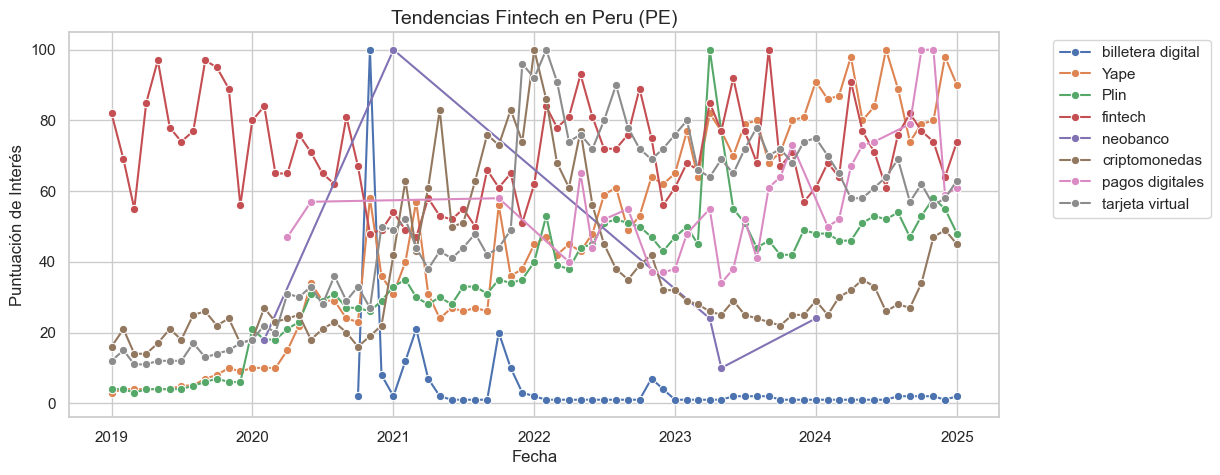

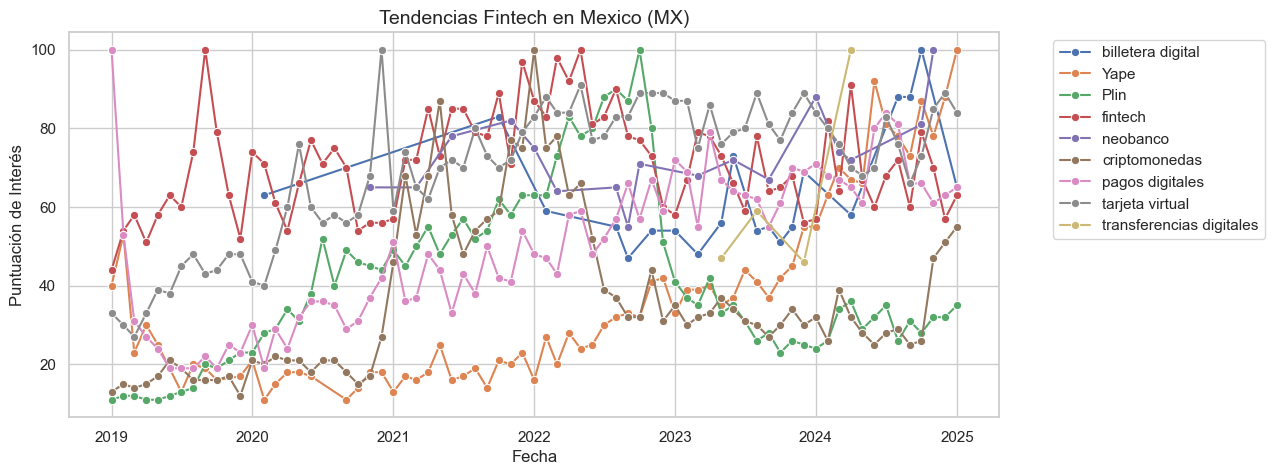

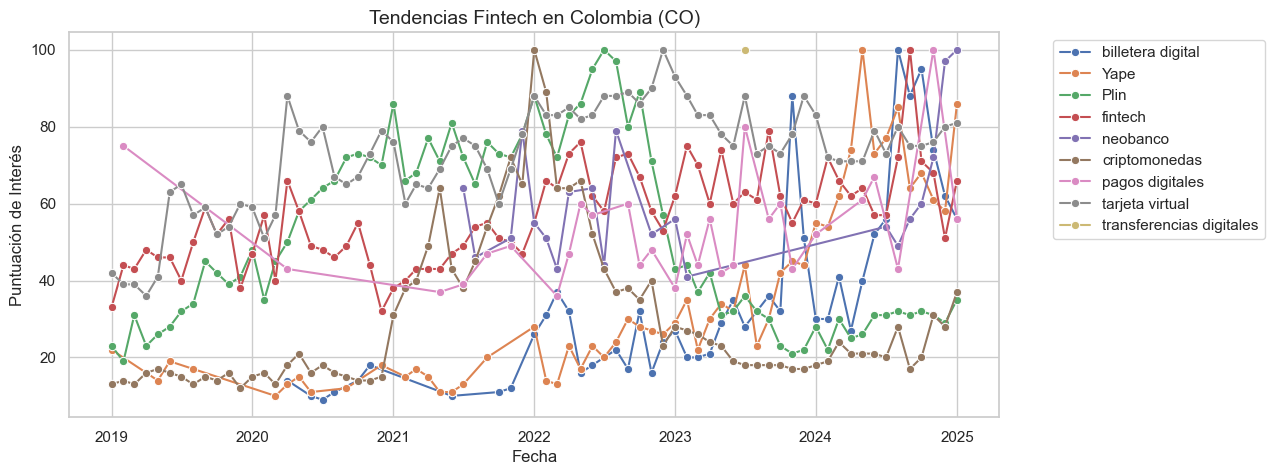

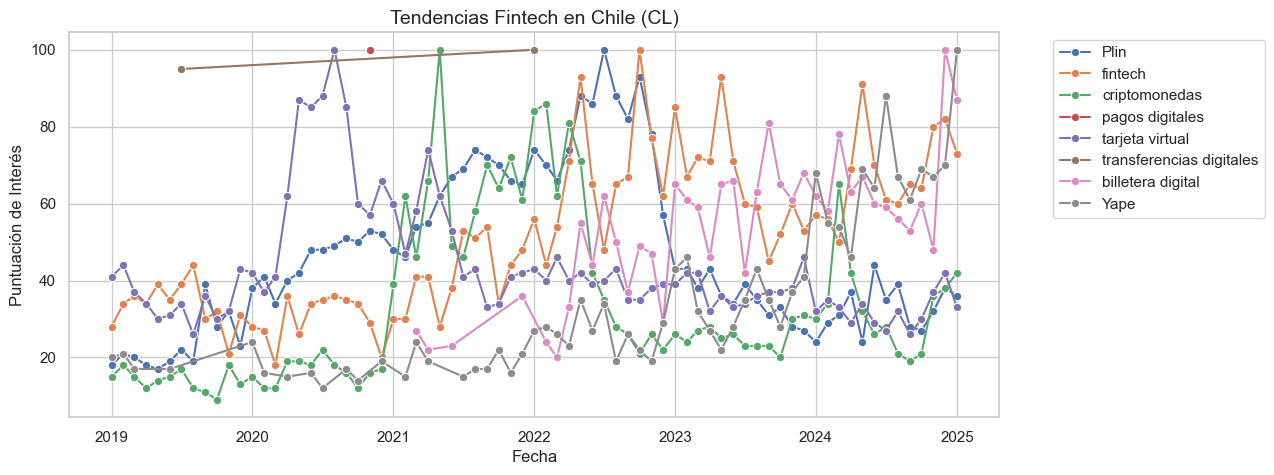

In [ ]:
# Visualización por País
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

for code, name in COUNTRIES.items():
    plt.figure(figsize=(12, 5))
    df_c = df_master[df_master['country_code'] == code]
    
    if df_c.empty: continue
    
    sns.lineplot(data=df_c, x="date", y="interest_score", hue="keyword", marker='o')
    plt.title(f"Tendencias Fintech en {name} ({code})", fontsize=14)
    plt.ylabel("Puntuación de Interés")
    plt.xlabel("Fecha")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
